In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import r2_score # R square
import matplotlib.pyplot as plt
import seaborn as sns
# from pycaret.regression import *

## Data processing

In [2]:
def data_handle(filename):
    dataset = pd.read_csv(filename)
    dataset = dataset.rename(
        columns={'Measured Depth m': 'DEPTH', 'Weight on Bit kkgf': 'WOB', 'Average Standpipe Pressure kPa': 'SPP',
                 'Average Surface Torque kN.m': 'ST',
                 'Rate of Penetration m/h': 'ROP', 'Average Rotary Speed rpm': 'RPM', 'Mud Flow In L/min': 'MFI',
                 'Mud Density In g/cm3': 'MDI', 'Diameter mm': 'DIA',
                 'Average Hookload kkgf': 'HookLoad', 'Hole Depth (TVD) m': 'TVD', 'USROP Gamma gAPI': 'UiSGamma'})
    dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
    dataset.drop(['TVD'], axis=1, inplace=True)
    col = list(dataset)
    col = col[0:-1]
    col.insert(13, col.pop(col.index('ROP')))
    dataset = dataset.loc[0:, col]
    df = pd.DataFrame()
    df = df.append(dataset, ignore_index=True)
    del df['Unnamed: 0.1']
    # del df['FORMATION']
    # del df['DIA']
    return df

In [3]:
df_9ad = data_handle('USROP_A 0 N-NA_F-9_Ad_F.csv')
df_7d = data_handle('USROP_A 1 N-S_F-7d_F.csv')
df_14d = data_handle('USROP_A 2 N-SH_F-14d_F.csv')
df_15sd = data_handle('USROP_A 4 N-SH_F-15Sd_F.csv')
df_5d = data_handle('USROP_A 5 N-SH_F-5d_F.csv')
df_9d = data_handle('USROP_A 6 N-SH_F-9d_F.csv')

#df_1 gather data for training and validatoin

df_1 = pd.DataFrame()
df_1 = df_1.append(df_9ad,ignore_index=True)
df_1 = df_1.append(df_7d, ignore_index=True)
df_1 = df_1.append(df_14d, ignore_index=True)
df_1 = df_1.append(df_5d, ignore_index=True)
df_1 = df_1.append(df_9d, ignore_index=True)

#df_2 define the well for testing
df_2 = pd.DataFrame()
df_2 = df_2.append(df_15sd, ignore_index=True)
# rate_size： ratio of known data in the well while drilling
rate_size = 0

df_1 = df_1.append(df_2.iloc[:int(df_2.shape[0] * rate_size)],ignore_index=True)
df_2 = df_2.iloc[int(df_2.shape[0] * rate_size):]
#print(df_2)
#data handle
print(df_1.shape)
print(df_2.shape)

(94179, 11)
(51708, 11)


In [4]:
df_2.head(5)

,DEPTH,WOB,SPP,ST,RPM,MFI,MDI,DIA,HookLoad,UiSGamma,ROP
0,1400.550,5.82258,16523.354801,12.148129,99.93,3544.773359,1.43,311.15,119.735076,126.46,19.961352
1,1400.577,5.82258,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
2,1400.605,5.82258,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
3,1400.660,5.82258,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
4,1400.687,5.82258,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784


## Data generality

/Users/2924813/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/2924813/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'X')

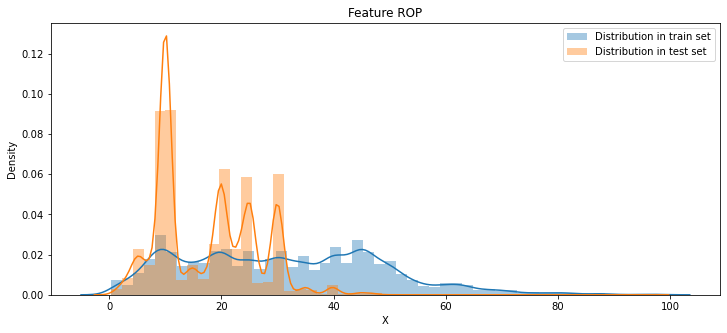

In [5]:
plt.figure(figsize=(12,5))
sns.distplot(df_1['ROP'],label='Distribution in train set')
sns.distplot(df_2['ROP'],label='Distribution in test set')
plt.legend()
plt.title('Feature ROP')
plt.xlabel('X')

<AxesSubplot:>

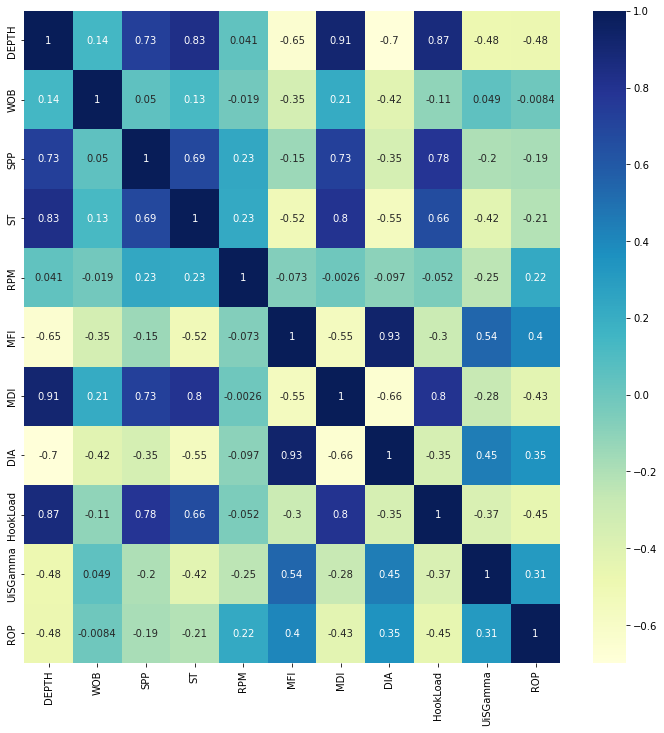

In [6]:
# use previous code to visualize the heat map of parameter correlations
plt.figure(figsize=(12,12))
corr = df_1.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap="YlGnBu",annot=True)

/Users/2924813/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/2924813/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/2924813/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

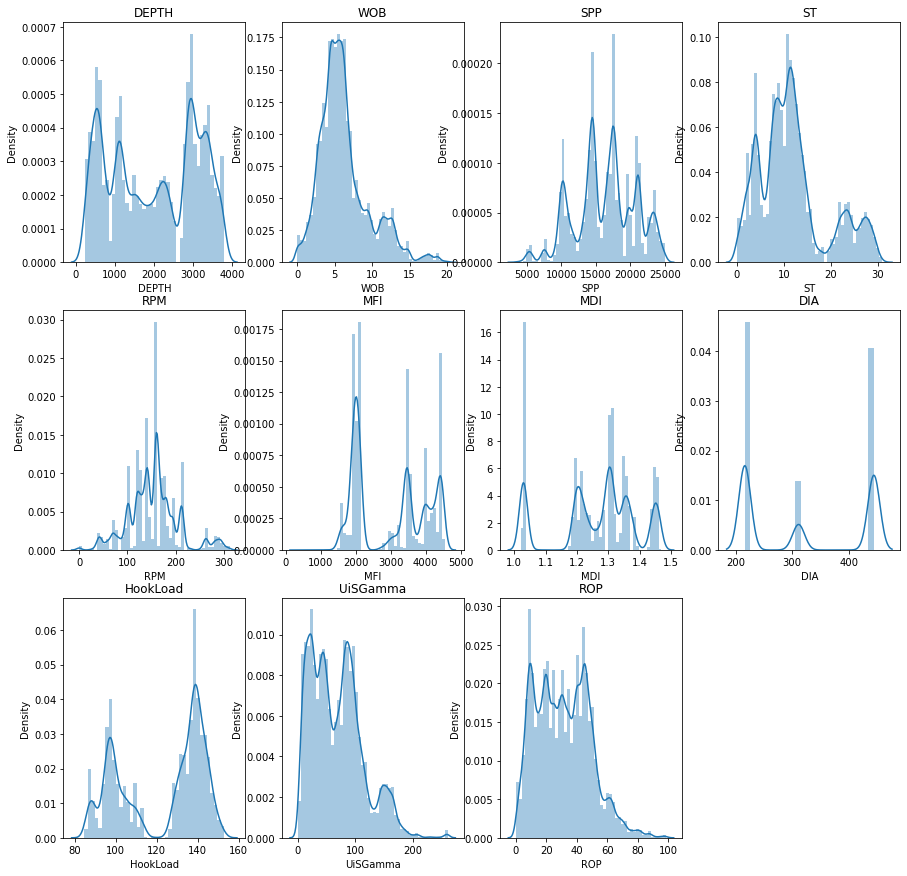

In [7]:
# Show the distribution of each parameter for both training+validation and testing datasets in different color
plt.figure(figsize=(15,15))
for i in range(len(df_1.columns)):
    plt.subplot(3,4,i+1)
    plt.title(df_1.columns.values[i])
    sns.distplot(df_1[df_1.columns.values[i]])
plt.show()

## Model training

In [14]:
# model evaluation function
# 把这段代码丰富一下，把pycaret那部分也加进来
# 定义一个参数，parameter_tune
# parameter_tune = true, 用pycaret来评估模型和保存结果
# parameter_tune = false,用下边这些代码
def evaluate_model(rf,df_1,df_2):
    if 0:
        reg = setup(data=df_1, numeric_features=['DIA'], target='ROP')  # default data split is 70 vs 30
        best_model = compare_models()  # 选取模型n_select= n 选择前n个auc最大的模型 默认为1
        predict_et = predict_model(best_model, data = df_2)
        print(predict_et)
        print('etmodel rmse:' ,np.sqrt(mean_squared_error(predict_et['ROP'], predict_et['Label'])))
        print('etmodel mae:' ,mean_absolute_error(predict_et['ROP'], predict_et['Label']))
        print('etmodel r2:' ,r2_score(predict_et['ROP'],predict_et['Label']))
        tuned_model, tuner = tune_model(best_model, return_tuner=True)
        predict_tuned = predict_model(tuned_model, data = df_2)
        print(predict_tuned)
        print('tunedetmodel rmse:' ,np.sqrt(mean_squared_error(predict_tuned['ROP'], predict_tuned['Label'])))
        print('tunedetmodel mae:' ,mean_absolute_error(predict_tuned['ROP'], predict_tuned['Label']))
        print('tunedetmodel r2:' ,r2_score(predict_tuned['ROP'],predict_tuned['Label']))
        return predict_et['ROP'],predict_tuned['ROP'],predict_et['Label'],predict_tuned['Label']
    else:
        X = df_1.iloc[:, 0:11]
        y = df_1.iloc[:, -1]
        #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
        rf.fit(X,y)
        X_2 = df_2.iloc[:, 0:11]
        y_2 = df_2.iloc[:, -1]
        train_predictions = rf.predict(X)
        test_predictions = rf.predict(X_2)
        return y,y_2,train_predictions,test_predictions

In [19]:
rf = MLPRegressor()
#MLlist =[MLPRegressor(),AdaBoostRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),KNeighborsRegressor(),LinearRegression()]


In [20]:
i = 1
test_r2 = 0
max_r2 = 0

while(i  < 2):
    print(i)
    i = i+1

    y, y_2, train_predictions, test_predictions = evaluate_model(rf, df_1, df_2)

    train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
    train_mae = mean_absolute_error(y, train_predictions)
    train_r2 = r2_score(y, train_predictions)

    test_rmse = np.sqrt(mean_squared_error(y_2, test_predictions))
    test_mae = mean_absolute_error(y_2, test_predictions)
    test_r2 = r2_score(y_2, test_predictions)
    print('train_rmse:', train_rmse)
    print('train_mae:', train_mae)
    print('train_r2:', train_r2)
    print('test_rmse:', test_rmse)
    print('test_mae:', test_mae)
    print('test_r2:', test_r2)
    if (test_r2 > max_r2):
        max_r2 = test_r2
        resultstr = ('train_rmse:' + str(train_rmse) + '\n' + 'train_mae:' +str(train_mae) + '\n' +
                 'train_r2:' + str(train_r2) + '\n' + 'test_rmse:' +str(test_rmse) + '\n' +
                 'test_mae:' + str(test_mae) + '\n' + 'test_r2:' +str(test_r2) + '\n')


1
train_rmse: 0.7784396897036449
train_mae: 0.5214458000922955
train_r2: 0.9980404743882676
test_rmse: 4.306375696855655
test_mae: 2.8703474950853227
test_r2: 0.7644748814750928


In [21]:
path = os.path.abspath(os.getcwd())
if not os.path.exists(path):
    data_pd = pd.DataFrame(columns=['rate', 'result'])
    data_pd['rate'] = np.linspace(0, 0.9, 10)
    data = data_pd.to_excel(path,index=False)

In [22]:
data = pd.read_excel('result.xlsx')
for i in range(data.shape[0]):
    if data['rate'][i] == rate_size:
        data['result'][i] = resultstr
data.to_excel('result.xlsx',index = False)

ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [ ]:
#上面存储的数据可能不全，你看下补充完整。把这块放到最后。
#最全的结果包括用不同方法在不同rate_size下的各类 评价参数的值
#比如参考你之前的结果整理，不同方法是不同的表里sheet，不同的rate——size vs 四个参数
#画图也放到最后

In [23]:
y = y.tolist()

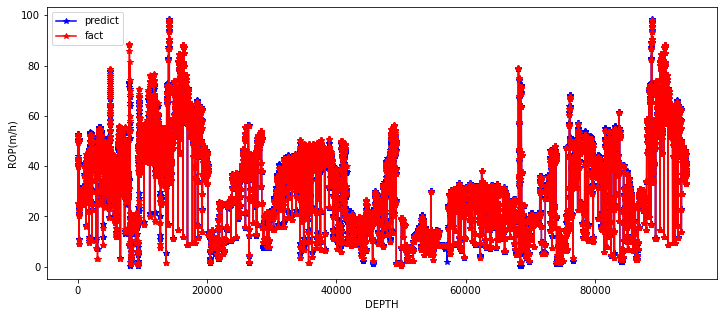

In [24]:
plt.figure(figsize=(12,5))
plt.plot(train_predictions, color='blue', marker='*', linestyle='-', label='predict')
plt.plot(y, color='red', marker='*', linestyle='-', label='fact')
plt.legend()
plt.xlabel('DEPTH')
plt.ylabel('ROP(m/h)')
plt.show()

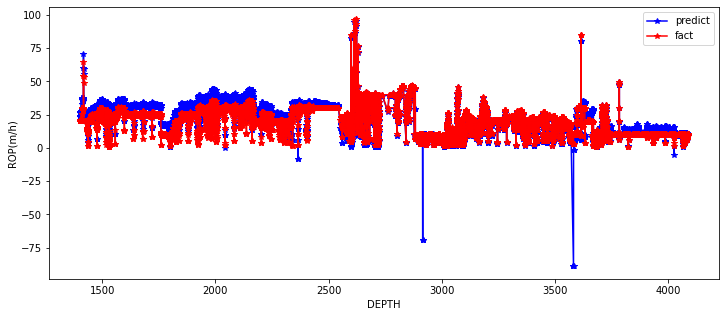

In [25]:
plt.figure(figsize=(12,5))
plt.plot(df_2['DEPTH'],test_predictions, color='blue', marker='*', linestyle='-', label='predict')
plt.plot(df_2['DEPTH'],y_2, color='red', marker='*', linestyle='-', label='fact')
plt.legend()
plt.xlabel('DEPTH')
plt.ylabel('ROP(m/h)')
plt.show()

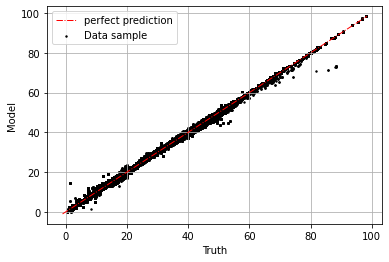

In [26]:
plt.scatter(y, train_predictions, s=2, c="black", label="Data sample", alpha=1)
plt.plot([-1, np.max([y, train_predictions])], [-1, np.max([y, train_predictions])], c="red", linewidth=1,
         linestyle="-.", label="perfect prediction")
plt.xlabel("Truth")
plt.ylabel("Model")
plt.legend()
plt.grid()

In [28]:
rate_size = 0.1
df_test= df_2.iloc[:int(df_2.shape[0] * rate_size)]
df_test

,DEPTH,WOB,SPP,ST,RPM,MFI,MDI,DIA,HookLoad,UiSGamma,ROP
0,1400.550,5.822580,16523.354801,12.148129,99.93,3544.773359,1.43,311.15,119.735076,126.46,19.961352
1,1400.577,5.822580,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
2,1400.605,5.822580,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
3,1400.660,5.822580,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
4,1400.687,5.822580,17590.318492,12.704014,99.00,3794.496989,1.43,311.15,119.735076,155.01,19.988784
...,...,...,...,...,...,...,...,...,...,...,...
5165,1734.315,4.099259,21187.658109,10.907555,119.00,3987.855834,1.47,311.15,129.779279,106.26,25.063704
5166,1734.385,4.099259,21187.658109,10.907555,119.00,3987.855834,1.47,311.15,129.779279,106.26,25.063704
5167,1734.455,4.099259,21187.658109,10.907555,119.00,3987.855834,1.47,311.15,129.779279,106.26,25.063704
5168,1734.489,4.099259,21079.065682,13.007717,119.80,3987.855834,1.47,311.15,129.779279,111.85,25.030176


In [33]:
int(df_2.shape[0] * rate_size)
int(df_2.shape[0] * (rate_size+0.1))

10341

In [34]:
df_test2 = df_2.iloc[int(df_2.shape[0] * rate_size):int(df_2.shape[0] * (rate_size+0.1))]
df_test2

,DEPTH,WOB,SPP,ST,RPM,MFI,MDI,DIA,HookLoad,UiSGamma,ROP
5170,1734.559,4.099259,21079.065682,13.007717,119.80,3987.855834,1.47,311.15,129.779279,111.85,25.030176
5171,1734.595,4.099259,21079.065682,13.007717,119.80,3987.855834,1.47,311.15,129.779279,111.85,25.030176
5172,1734.629,4.099259,21096.716261,16.427090,119.41,3987.855834,1.47,311.15,129.779279,111.85,25.054560
5173,1734.699,4.099259,21096.716261,16.427090,119.41,3987.855834,1.47,311.15,129.779279,111.85,25.054560
5174,1734.769,4.099259,21093.613620,16.675205,119.59,3987.855834,1.47,311.15,129.779279,98.14,25.057608
...,...,...,...,...,...,...,...,...,...,...,...
10336,2003.755,5.669622,22382.657444,13.050000,119.44,3987.855834,1.46,311.15,134.877868,90.35,14.078712
10337,2003.795,5.669622,22382.657444,13.050000,119.44,3987.855834,1.46,311.15,134.877868,90.35,14.078712
10338,2003.810,5.669622,22382.657444,13.050000,119.44,3987.855834,1.46,311.15,134.877868,90.35,14.078712
10339,2003.822,5.669622,22382.657444,13.050000,119.44,3987.855834,1.46,311.15,134.877868,90.35,14.078712


0.0
(94179, 11)
(5170, 11)
1
train_rmse: 13.966168823130227
train_mae: 13.628084738317709
train_r2: 0.3692524424069715
test_rmse: 16.25083265889677
test_mae: 16.240509833221957
test_r2: -10.305501956255187
0.1
(99349, 11)
(5171, 11)
1
train_rmse: 16.431804518154614
train_mae: 15.931599004046015
train_r2: 0.09124738002435073
test_rmse: 19.597092670710285
test_mae: 19.573979770615257
test_r2: -4.6027391057314935
0.2
(104520, 11)
(5171, 11)
1
train_rmse: 1.0292320859135462
train_mae: 0.5833196760509706
train_r2: 0.9963709117840914
test_rmse: 0.6498272069024066
test_mae: 0.42387456328303696
test_r2: 0.9875723811683704


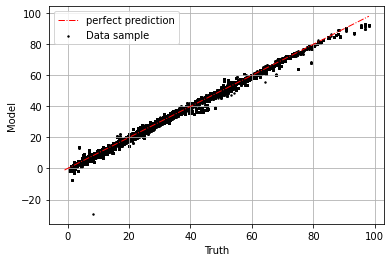

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.30000000000000004
(109691, 11)
(5171, 11)
1
train_rmse: 0.7543275833570199
train_mae: 0.5324609982348713
train_r2: 0.9979790369798227
test_rmse: 4.478845622995593
test_mae: 2.3350089697261938
test_r2: 0.8283030890193273


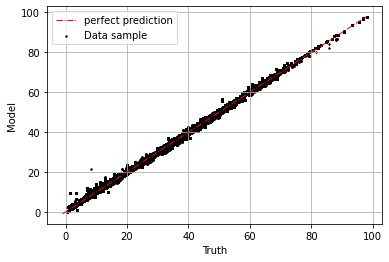

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.4
(114862, 11)
(5171, 11)
1
train_rmse: 5.860155827537773
train_mae: 5.691692620616639
train_r2: 0.8749900841942763
test_rmse: 5.66453479459209
test_mae: 4.697220835496832
test_r2: -2.3419314612084965
0.5
(120033, 11)
(5170, 11)
1
train_rmse: 3.07854748106147
train_mae: 2.9366626100717452
train_r2: 0.9663783922102904
test_rmse: 3.7492515811884015
test_mae: 3.7353817192030245
test_r2: 0.6825025201573696


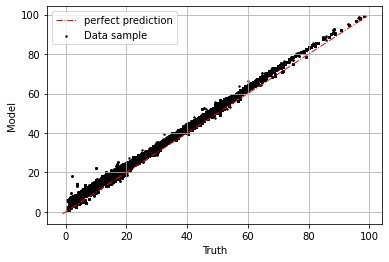

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.6000000000000001
(125203, 11)
(5171, 11)
1
train_rmse: 1.7312855521325665
train_mae: 1.637837040452558
train_r2: 0.9891660518710735
test_rmse: 2.2793270958039984
test_mae: 2.041692676168924
test_r2: 0.8845178513165172


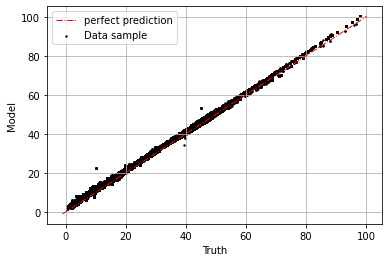

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.7000000000000001
(130374, 11)
(5171, 11)
1
train_rmse: 0.5599979718062765
train_mae: 0.341500271534968
train_r2: 0.9988519071702897
test_rmse: 2.4095892753432846
test_mae: 2.162708525738563
test_r2: 0.9364569302806256


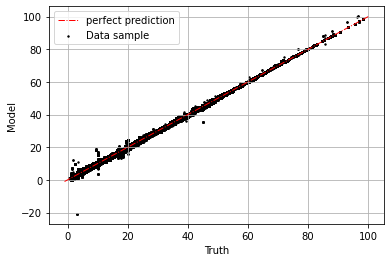

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.8
(135545, 11)
(5171, 11)
1
train_rmse: 3.223385188210701
train_mae: 3.081583107449342
train_r2: 0.9615199546691637
test_rmse: 2.350993555250906
test_mae: 2.245378664951827
test_r2: -0.8879315143129913
0.9
(140716, 11)
(5171, 11)
1
train_rmse: 3.2847484835563274
train_mae: 3.160882735977859
train_r2: 0.9601594660714831
test_rmse: 2.965023265447552
test_mae: 2.950416197392867
test_r2: -14.478544684962506
0.0
(94179, 11)
(5170, 11)
1
train_rmse: 1.4696169185011658
train_mae: 1.111960516027456
train_r2: 0.99301591866328
test_rmse: 1.9355239723219122
test_mae: 1.5573915251816246
test_r2: 0.8396253497548547


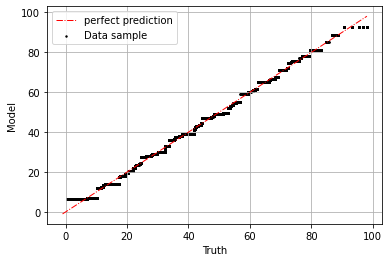

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.1
(99349, 11)
(5171, 11)
1
train_rmse: 1.4398043986224132
train_mae: 1.1087787641927438
train_r2: 0.9930227843119377
test_rmse: 2.0814784885136692
test_mae: 1.840923585309369
test_r2: 0.9367936137104642


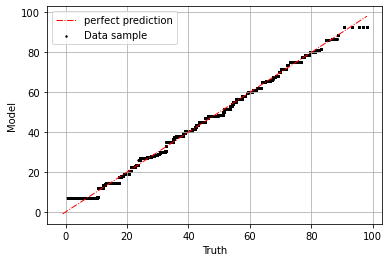

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.2
(104520, 11)
(5171, 11)
1
train_rmse: 1.4395486532283288
train_mae: 1.0906163377536702
train_r2: 0.9929005682766384
test_rmse: 1.196667057951831
test_mae: 0.9415026395675572
test_r2: 0.9578557028446413


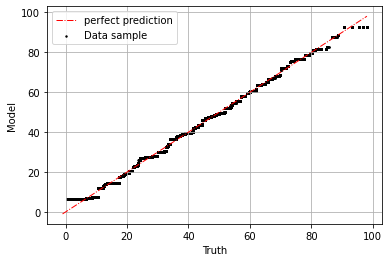

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.30000000000000004
(109691, 11)
(5171, 11)
1
train_rmse: 1.6892427120456768
train_mae: 1.3434712967919358
train_r2: 0.9898650293093814
test_rmse: 1.9053105751943507
test_mae: 1.6862531844310817
test_r2: 0.9689285263848649


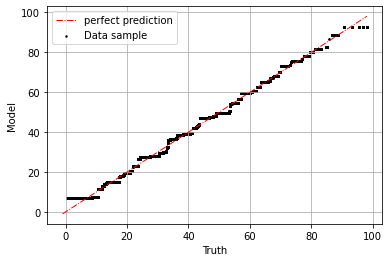

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.4
(114862, 11)
(5171, 11)
1
train_rmse: 1.4717284061744063
train_mae: 1.1384268561334867
train_r2: 0.9921153670896727
test_rmse: 2.2707888666315164
test_mae: 2.0110694390047796
test_r2: 0.46294031381639267


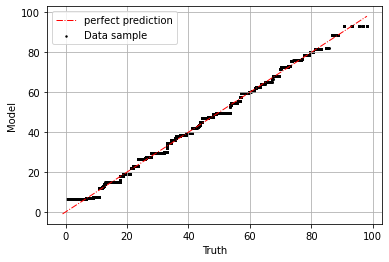

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.5
(120033, 11)
(5170, 11)
1
train_rmse: 1.6094779974055333
train_mae: 1.3020610182836592
train_r2: 0.9908103948129724
test_rmse: 1.1735692734253214
test_mae: 0.821117407215478
test_r2: 0.9688922517061914


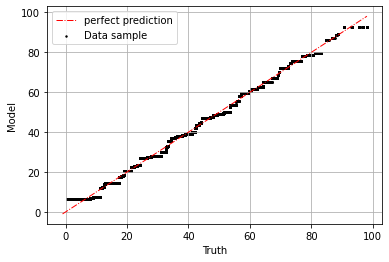

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.6000000000000001
(125203, 11)
(5171, 11)
1
train_rmse: 1.3555914644681517
train_mae: 0.975655633732639
train_r2: 0.9933578757775551
test_rmse: 1.3615643024964184
test_mae: 1.0198546159788875
test_r2: 0.95879234864817


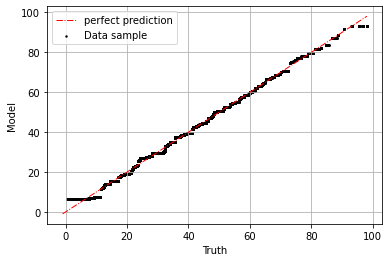

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.7000000000000001
(130374, 11)
(5171, 11)
1
train_rmse: 1.559620416812788
train_mae: 1.250431427137027
train_r2: 0.9910948360372512
test_rmse: 1.815363516274333
test_mae: 1.5923904865656238
test_r2: 0.9639330552532874


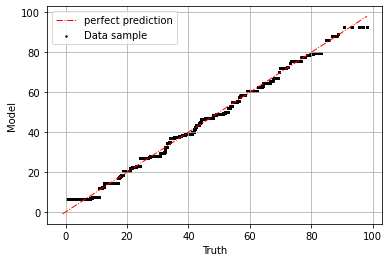

/var/folders/m3/ylmykczd3w1cqxm896sp95c0hgtflt/T/ipykernel_63422/3159095852.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd['result'][k] = resultstr


0.8
(135545, 11)
(5171, 11)
1
train_rmse: 1.571749234383494
train_mae: 1.247832835789762
train_r2: 0.9908509146719185
test_rmse: 2.539705947693511
test_mae: 2.5285350611463344
test_r2: -1.2031812700909628
0.9
(140716, 11)
(5171, 11)
1
train_rmse: 1.4511041356735492
train_mae: 1.1558379851893517
train_r2: 0.992224683646692
test_rmse: 2.1013433740927545
test_mae: 2.081144134742571
test_r2: -6.774419378183111


In [35]:
#MLlist =[MLPRegressor(),AdaBoostRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),KNeighborsRegressor(),LinearRegression()]
MLlist =[MLPRegressor(),AdaBoostRegressor()]
rate_size_list = np.linspace(0,0.9,10).tolist()
path = 'result.xlsx'
writer = pd.ExcelWriter(path)
for MLname in MLlist:
    data_pd = pd.DataFrame(columns=['rate', 'result'])
    data_pd['rate'] = np.linspace(0, 0.9, 10)
    rf = MLname
    for rate_size in rate_size_list:
        print(rate_size)
        df_train= pd.DataFrame()
        df_test=pd.DataFrame()
        df_train = df_1.append(df_2.iloc[:int(df_2.shape[0] * rate_size)], ignore_index=True)
        # test data is the followinng data of rate_size+0.1
        df_test = df_2.iloc[int(df_2.shape[0] * rate_size):int(df_2.shape[0] * (rate_size+0.1))]
        print(df_train.shape)
        print(df_test.shape)

        i = 1
        test_r2 = 0
        max_r2 = 0
        while(i<2):
            print(i)
            i = i + 1

            y, y_2, train_predictions, test_predictions = evaluate_model(rf, df_train, df_test)

            train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
            train_mae = mean_absolute_error(y, train_predictions)
            train_r2 = r2_score(y, train_predictions)

            test_rmse = np.sqrt(mean_squared_error(y_2, test_predictions))
            test_mae = mean_absolute_error(y_2, test_predictions)
            test_r2 = r2_score(y_2, test_predictions)
            print('train_rmse:', train_rmse)
            print('train_mae:', train_mae)
            print('train_r2:', train_r2)
            print('test_rmse:', test_rmse)
            print('test_mae:', test_mae)
            print('test_r2:', test_r2)
            if (test_r2 > max_r2):
                max_r2 = test_r2
                resultstr = ('train_rmse:' + str(train_rmse) + '\n' + 'train_mae:' + str(train_mae) + '\n' +
                             'train_r2:' + str(train_r2) + '\n' + 'test_rmse:' + str(test_rmse) + '\n' +
                             'test_mae:' + str(test_mae) + '\n' + 'test_r2:' + str(test_r2) + '\n')
                plt.scatter(y, train_predictions, s=2, c="black", label="Data sample", alpha=1)
                plt.plot([-1, np.max([y, train_predictions])], [-1, np.max([y, train_predictions])], c="red", linewidth=1,
                         linestyle="-.", label="perfect prediction")
                plt.xlabel("Truth")
                plt.ylabel("Model")
                plt.legend()
                plt.grid()
                plt.show()
                for k in range(data_pd.shape[0]):
                    if data_pd['rate'][k] == rate_size:
                        data_pd['result'][k] = resultstr

        data_pd.to_excel(writer, sheet_name=str(MLname), index=False)
writer.save()


In [36]:
# visualization代码的内容加到这后面
data = pd.read_excel('result.xlsx')

print(data)

train_rmse=[]
train_mae=[]
train_r2=[]
test_rmse=[]
test_mae=[]
test_r2=[]

for i in range(data.shape[0]):
#    print(str(data['result'][i]))
    result = str(data['result'][i]).split('\n')
    train_rmse.append(float(result[0].split(':')[1]))
    train_mae.append(float(result[1].split(':')[1]))
    train_r2.append(float(result[2].split(':')[1]))
    test_rmse.append(float(result[3].split(':')[1]))
    test_mae.append(float(result[4].split(':')[1]))
    test_r2.append(float(result[5].split(':')[1]))
x_values = data['rate']
plt.plot(x_values,train_rmse, color='blue', marker='*', linestyle='-', label='train_rmse')
plt.plot(x_values,train_mae, color='red', marker='*', linestyle='-', label='train_mae')
plt.plot(x_values,train_r2, color='green', marker='*', linestyle='-', label='train_r2')
plt.plot(x_values,test_rmse, color='yellow', marker='*', linestyle='-', label='test_rmse')
plt.plot(x_values,test_mae, color='black', marker='*', linestyle='-', label='test_mae')
plt.plot(x_values,test_r2, color='magenta', marker='*', linestyle='-', label='test_r2')
plt.legend()
plt.xlabel('DATA RATE')
plt.ylabel('METRICS')
plt.show()

   rate                                             result
0   0.0                                                NaN
1   0.1                                                NaN
2   0.2  train_rmse:1.0292320859135462\ntrain_mae:0.583...
3   0.3  train_rmse:0.7543275833570199\ntrain_mae:0.532...
4   0.4                                                NaN
5   0.5  train_rmse:3.07854748106147\ntrain_mae:2.93666...
6   0.6  train_rmse:1.7312855521325665\ntrain_mae:1.637...
7   0.7  train_rmse:0.5599979718062765\ntrain_mae:0.341...
8   0.8                                                NaN
9   0.9                                                NaN


IndexError: list index out of range